In [1]:

import os
from glob import glob

import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import mapping


In [2]:
def open_clean_band(band_path, clip_extent, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    try:
        clip_bound = clip_extent.geometry
    except Exception as err:
        print("Oops, I need a geodataframe object for this to work.")
        print(err)

    cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).rio.clip(clip_bound,
                                                           from_disk=True).squeeze()

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((sentinel_xr_clip < valid_range[0]) | (
            sentinel_xr_clip > valid_range[1]))
        cleaned_band = sentinel_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band

In [3]:
def process_bands(paths, crop_layer, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same 
        resolution, crs and spatial extent).
    
    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.
        
    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        #cleaned["band"] = i+1
        #cleaned.rio.to_raster(
        #    "/home/jovyan/results/bands_cropped/"+str(i)+"cropped_to_aoi.tiff",
        #    tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
        #    windowed=True,  # rioxarray: read & write one window at a time
        #)
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        allBandStack = xr.concat(all_bands, dim="band")
        
        #with rio.open(paths[0]) as src:
        #    meta = src.meta
        #with rio.open('/home/jovyan/results/bands_cropped/allbands_croppped.tiff', 'w', **meta) as dst:
        #    dst.write(arr_st, indexes=4)
                
        return allBandStack
    else:
        print("Returning a list of xarray objects.")
        return all_bands
        

In [4]:
sentinel_data_path = os.path.join("/home/jovyan/",
                                      "satData/sololo"
                                      #"satData/S2B_MSIL2A_20230612T073619_N0509_R092_T37NCC_20230612T101141.SAFE/GRANULE/L2A_T37NCC_A032722_20230612T075442/",
                                      #"IMG_DATA",
                                      #"R10m"
                                     # "RGB"
                                  )

glob(os.path.join(sentinel_data_path, "*"))


all_sentinel_bands = glob(os.path.join(sentinel_data_path,
                                          "*B*.jp2"))
                                        # "*TCI*.jp2"))
all_sentinel_bands.sort()

all_sentinel_bands

['/home/jovyan/satData/sololo/T37NDD_20230910T073619_B02_10m.jp2',
 '/home/jovyan/satData/sololo/T37NDD_20230910T073619_B03_10m.jp2',
 '/home/jovyan/satData/sololo/T37NDD_20230910T073619_B04_10m.jp2',
 '/home/jovyan/satData/sololo/T37NDD_20230910T073619_B08_10m.jp2']

In [5]:
# Download data and set working directory
#data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME,
                      'vector_data'
                     ))

In [6]:
# Open up boundary extent using GeoPandas
#aoi_boundary_path = os.path.join("aoi.gpkg")
aoi_boundary_path = os.path.join("sololo_area.gpkg")
aoi_boundary = gpd.read_file(aoi_boundary_path)

# Get a list of required bands - bands 2 through 5
all_sentinel_bands = glob(os.path.join(sentinel_data_path,
                                           "*B[02-08]*.jp2"))
                                           #"*TCI*.jp2"))
all_sentinel_bands.sort()

# Get CRS of landsat data and reproject fire boundary
# Reproject your vector layer
crs_sat = es.crs_check(all_sentinel_bands[0])
crs_aoi = aoi_boundary.crs

# Reproject aoi boundary for clipping
aoi_reprojected = aoi_boundary.to_crs(crs_sat)

In [7]:
processed_stack = process_bands(all_sentinel_bands, 
                                aoi_reprojected, 
                                stack=True)
processed_stack.shape

I'm stacking your data now.


(4, 10980, 10980)

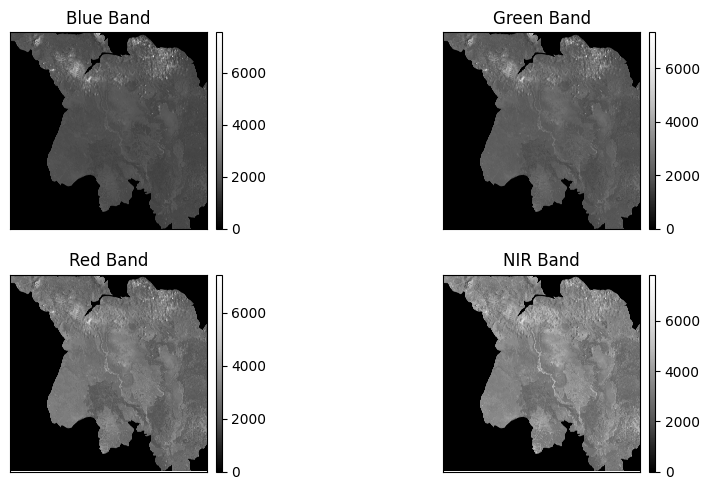

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot using earthpy
band_titles = ["Blue Band",
               "Green Band",
               "Red Band",
               "NIR Band"]

# Plot the final data
ep.plot_bands(processed_stack,
              cols=2,
              figsize=(10,5),
              title=band_titles)
plt.suptitle("Cleaned and Cropped Sentinel Bands")
plt.show()

In [9]:
processed_stack.rio.to_raster(
    "/home/jovyan/results/sololoCropped4bands_to_aoi.tiff",
    tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
    windowed=True,  # rioxarray: read & write one window at a time
)
